In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import random as rn

In [3]:
class particle: 
    def __init__(self,m,x,y,vx=0,vy=0): 
        """
        Defines the particle. Each particle has a mass, a position and momentum
        Inputs: 
            - m (float): mass of the particle 
            - x,y (float): x and y components respectively of the particle's position 
            - vx,vy (float): x and y components respectively of the particle's velocity
        """
        self.mass = m 
        self.position = (x,y)
        self.momentum = (self.mass*vx,self.mass*vy)
    
def evolve(self,position,momentum,mass,f_current,f_next,dt):
    """
    Evolves the particle's position and momentum using the leap frog method seen in class
    Inputs: 
        - f_current (array): The forces on the particle 
        - f_new (array): changed forces on the particle 
        - dt (float): time step in seconds 
    """
    x = position+(momentum/self.mass)*dt + 0.5*f_current*dt**2
    v = (momentum/mass) + 0.5*(f_current+f_next)*dt
    return x,v 

def calculate_dist(grid,pos):
    """
    Calculates the position between a grid point and a particle's position
    """
    return np.sqrt((grid[0]-pos[0])**2+(grid[1]-pos[1])**2)

In [15]:
class system: 
    def __init__(self,npart,size,init_mass,npart_specific=None):
        """
        Defines the total system of particles and puts them in a list. 
        Inputs: 
            - npast (int): total number of particles 
            - size (int): (x,y) of the size of the grid 
        """
        def initial_condition(size,npart,npart_specific=None): 
            """
            Depending on the grid size, generates random position on the grid. 
            Makes sure that the particles do not get generated on top of each other.
            Inputs:
                - size (array): size of grid. In the format of (x,y)
                - npart (int): total number of particles of the system
                - npar_specific (array): specific boundary condition pre-defined by the user
            """
            init_cond = []
            if npart_specific is None: 
                l = 0
            else: 
                l = len(npart_specific)
                for k in range(l):
                    pos = (npart_specific[k][0], npart_specific[k][1])
                    init_cond.append(pos)

            for p in range(npart-l):
                pos = (rn.random())*(size[0]-1), (rn.random())*(size[1]-1)
                
                init_cond.append(pos)
                #Small code block to make sure no two particles are generated on-top 
                #of each other. Although it is highly unlikely but just to make sure 
                #j = 0 
                #if p!=0:
                #    while j<npart: 
                #        if init_cond[-2][0] == init_cond[-1][0] and init_cond[-2][1] == init_cond[-1][1]:
                #            x_in, y_in =  rn.random()*size[0], rn.random*size[1]
                #            init_cond.pop()
                #            init_cond.append([x_in,y_in])
                #            j = -1
                #        else: 
                #            j += 1
                            
            return init_cond
        
        self.nparticles = npart
        init_cond = initial_condition(size,npart,npart_specific=npart_specific)
        self.particles = np.asarray([particle(m,x[0],x[1]) for m,x in zip(init_mass,init_cond)])   
        self.momenta = np.asarray([self.particles[i].momentum for i in range(npart)])
        self.pos = np.asarray([self.particles[i].position for i in range(npart)])
        self.masses = init_mass
        
    def evolve_system(self,acc,acc_new,dt,size,type_p = False):
        self.pos, self.momenta = evolve(self.pos,self.momenta,self.masses,acc,acc_new,dt)
        if type_p == True:
            self.pos = self.pos%(size-1)  
        

In [108]:
class grid: 
    def __init__(self,size,particleList,soft=0.1,G=1):
        self.size = size
        self.soft = soft
        self.G = G
        self.posP = particleList.pos
        self.intPos = np.round(self.posP)
        self.gridPos = self.grid_Maker(self.posP)
        self.mass = particleList.masses
        x, y = np.arange(size[0],dtype=float), np.arange(size[0],dtype=float)
        self.mesh = np.array(np.meshgrid(x,y))
        
        # Density assignment using the Cloud-In-Cell method 
        self.density_assignment()

        self.green()
        
        self.pot()
    
    def grid_Maker(self,posP):
        """
        Function that generates the closest 4 gridpoints on the grid for each particle. 
        """
        gridPos = []
        #top right corner grid 
        gridPos = []
        gridPos.append(np.ceil(self.posP))  
        #top left corner grid
        gridPos.append(np.asarray([np.floor(self.posP[:,0]),np.ceil(self.posP[:,1])]).T) 
        #bottom right corner grid
        gridPos.append(np.asarray([np.ceil(self.posP[:,0]),np.floor(self.posP[:,1])]).T) 
        #bottom left corner grid 
        gridPos.append(np.floor(self.posP)) 
        
        return np.transpose(np.asarray(gridPos),axes=[1,0,-1])
    
    def updatePos(self,particleList):
        self.posP = particleList.pos
        self.intPos = np.round(self.posP)
        self.gridPos = self.grid_Maker(self.posP)
        self.mass = particleList.masses
        self.gridDensity = self.density(self.posP,self.gridPos,self.mass,size) 
    
    #Step 1: Define the density assignment function
    def density_assignment(self):
        """
        Function that assigns the density based off the CIC method (cloud-in-cell) method
        """
        new_gridD = np.zeros((self.size[0],self.size[1]))
        
        for i in range(self.posP.shape[0]):
            for j in range(4):
                d = calculate_dist(self.gridPos[i,j],self.posP[i])
                new_gridD[int(self.gridPos[i,j,0]),int(self.gridPos[i,j,1])] += self.mass[i]*(1-d/np.sqrt(2))
        
        self.densities = new_gridD
    
    #Step 2: Define the green function of the grid
    def green(self):
        r = np.sum(self.mesh**2,axis=0)
        r[r<self.soft**2] = self.soft**2
        r += self.soft**2
        r = np.sqrt(r)
        
        g = 1/(4*np.pi*r)
        
        #To get periodicity, we flip the corners to get the same behavior around
        h_x,h_y = self.size[0]//2, self.size[1]//2
        
        #For now works for square grids only

        try:
            g[h_x:, :h_y] = np.flip(g[:h_x,:h_y],axis=0)
            g[:,h_y:] = np.flip(g[:,:h_y],axis=1)
        except: 
            g[h_x:, :h_y+1] = np.flip(g[:h_x+1,:h_y+1],axis=0)
            g[:,h_y:] = np.flip(g[:,:h_y+1],axis=1)
        self.g = g
        print(self.g.shape)
            
            
    def pot(self):
        #To get the potential, we just multiply the fourier transformed density with
        #the fourier transformed green function
        
        ffD = np.fft.rfft2(self.densities)
        ffG = np.fft.rfft2(self.g)
        ffV = ffD*ffG
        
        V = np.fft.irfft2(ffV)
        
        #Need to shift and average the potential to center it back to particle
        for i in range(2):
            V = 0.5*(np.roll(V,1,axis=i)+V)
            
        return V 
    
    def forces_mesh(self): 
        fmesh = np.zeros([2,self.size[0],self.size[1]])
        
        V = self.pot()
        
        #Gradient in each direction
        for i in range(2):
            fmesh[i] = 0.5*(np.roll(V,1,axis=i) - np.roll(V,-1,axis=i))
    
        fmesh *= -self.densities*self.G
        return fmesh 
    
    #Interpolate forces to particles
    #def forces_pctls(self):
        
        
    #    return 0

(500, 500)
[[0.0005627 0.0005627 0.0005627 ... 0.0005627 0.0005627 0.0005627]
 [0.0005627 0.0005627 0.0005627 ... 0.0005627 0.0005627 0.0005627]
 [0.0005627 0.0005627 0.0005627 ... 0.0005627 0.0005627 0.0005627]
 ...
 [0.0005627 0.0005627 0.0005627 ... 0.0005627 0.0005627 0.0005627]
 [0.0005627 0.0005627 0.0005627 ... 0.0005627 0.0005627 0.0005627]
 [0.0005627 0.0005627 0.0005627 ... 0.0005627 0.0005627 0.0005627]]


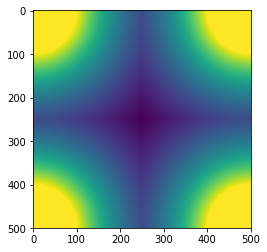

In [103]:
npart = 2
size = (500,500)
init_mas = [rn.random() for t in range(npart)]
s = system(npart,size,init_mas,npart_specific=None)
g = grid(size,s,soft=100)
print (g.g)
plt.imshow(g.g)

In [10]:
np.meshgrid([10,60],[600,900])


[array([[10, 60],
        [10, 60]]), array([[600, 600],
        [900, 900]])]